In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import random
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline

In [2]:
NOTEBOOK_ROOT = os.getcwd()
# Gbp/Usd Bid and Ask price in the market
M = pd.read_csv(os.path.join(NOTEBOOK_ROOT, "2.csv"), encoding='utf-16-le', index_col=0)
M_raw = pd.read_csv(os.path.join(NOTEBOOK_ROOT, "2.csv"), encoding='utf-16-le') # Without reindex
M.index = pd.to_datetime(M.index, format="%m/%d/%Y %H:%M:%S.%f")
M_raw.DateTime = pd.to_datetime(M_raw.DateTime, format="%m/%d/%Y %H:%M:%S.%f")
M['Action'] = 1
M_raw['Action']=1
M_raw['Side']='F'
M_raw['Spread']=M_raw['Ask']-M_raw['Bid']

In [3]:
# Order Information
order = pd.read_csv(os.path.join(NOTEBOOK_ROOT, "MMOrderSet.csv"),index_col = False)
order['DateTime'] = pd.to_datetime(order['Time'], format = "%m-%d-%Y %H:%M:%S")
order.drop(['Time'],axis=1,inplace=True)
order = order[['DateTime', 'Side']]
order['Action'] = 2

In [4]:
# Interweave orders and tick prices based on their respective times of arrival
data = pd.concat([M_raw, order], axis=0, sort=False).sort_values(by=['DateTime'])
data.reset_index(drop=True, inplace=True)

In [480]:
# Parameters
X=10 # MM reaction time
Y=5 #Order succession time
p=0.5 # execution probability
q=0.25 # follow-up probability 
K=10 # MM net open position limit
net_Pos=0 
long_list = []
short_list = []
temp_PnL, realized_PnL = 0, 0

In [1093]:
result_11 = MM_Simulation(data_1,p,q,K,X,1)

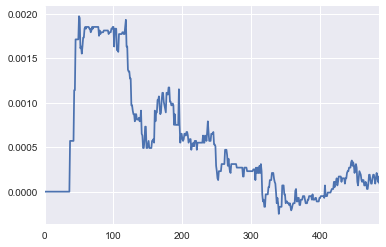

In [1094]:
_ = result_11['MM_PnL'].plot()

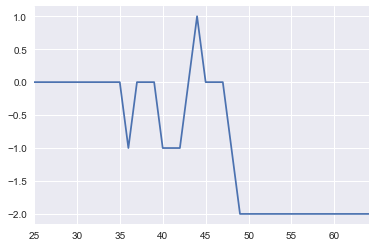

In [1095]:
_ = result_11['net_Pos'][25:65].plot()

In [1122]:
result_12=MM_Simulation(data_1,p,q,K,X,2)
result_12.reset_index(drop=True, inplace=True)

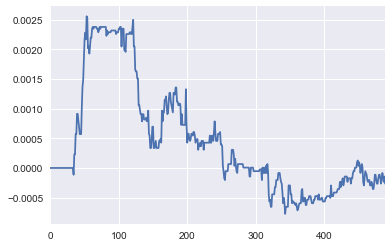

In [1123]:
_ = result_12['MM_PnL'].plot()

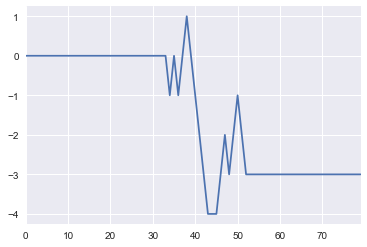

In [1124]:
_ = result_12['net_Pos'][:80].plot()

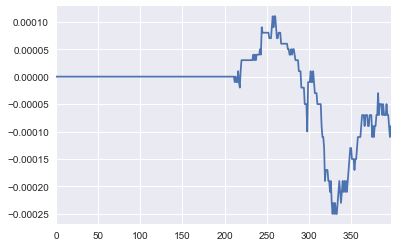

In [1132]:
result_21=MM_Simulation(data_2,p,q,K,X,1)
_ = result_21['MM_PnL'].plot()

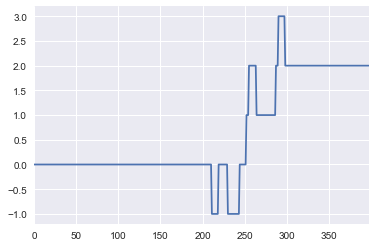

In [1133]:
_ = result_21['net_Pos'].plot()

In [1137]:
result_22=MM_Simulation(data_2,p,q,K,X,2)
result_22.reset_index(drop=True, inplace=True)

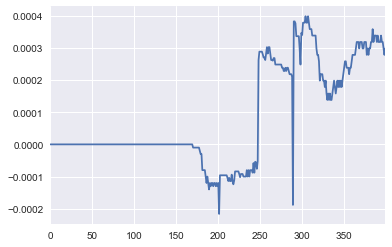

In [1138]:
_ = result_22['MM_PnL'].plot()

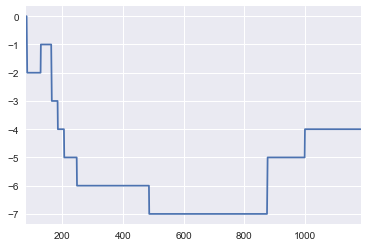

In [1139]:
_ = result_32['net_Pos'][80:].plot()


In [1140]:
result_32=MM_Simulation(data_3,p,q,K,X,2)
result_32.reset_index(drop=True, inplace=True)

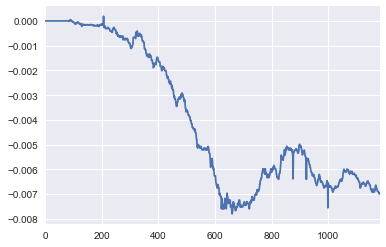

In [1141]:
_ = result_32['MM_PnL'].plot()

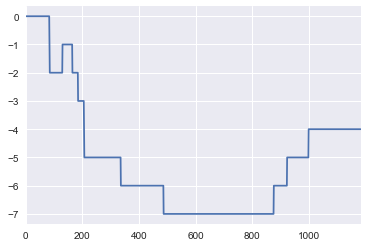

In [1142]:
_ = result_32['net_Pos'].plot()

In [1083]:
result_41 = MM_Simulation(data_4,p,q,K,X,1)
result_41.reset_index(drop=True, inplace=True)

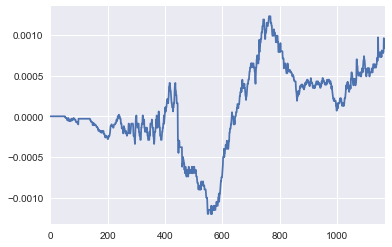

In [1084]:
_ = result_41['MM_PnL'].plot()

In [1143]:
result_42 = MM_Simulation(data_4,p,q,K,X,2)
result_42.reset_index(drop=True, inplace=True)

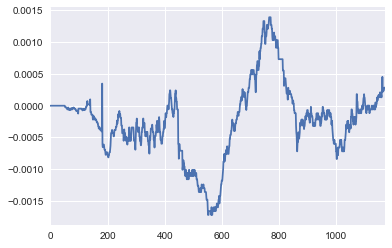

In [1144]:
_ = result_42['MM_PnL'].plot()

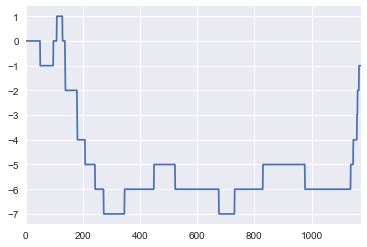

In [1145]:
_ = result_42['net_Pos'].plot()

In [1088]:
def insert_order(count,df_orders, idx, succession_time, realized_PnL, temp_PnL,long_list,short_list): # succession time in unit of millisecond    
    signal = df_orders.at[idx,'Side']
    Bid = df_orders.at[idx,'Bid']
    Ask = df_orders.at[idx,'Ask']
    Spread = df_orders.at[idx,'Spread']
    MM_Bid = df_orders.at[idx,'MM_Bid']
    MM_Ask = df_orders.at[idx,'MM_Ask']
    net_Pos = df_orders.at[idx,'net_Pos']
    if(signal=='B'):
        if(net_Pos <= -K):
            short_list.append(temp_1.at[i,'MM_Ask'])
            # Hedge with the market (with k=0.5*b/o spread as hedge cost)
            realized_PnL += short_list[0]-df_orders.at[idx,'Ask']-0.5*(df_orders.at[i,'Ask']-df_orders.at[i,'Bid'])
            executed = short_list.pop(0)
            temp_PnL = sum([x-df_orders.at[i,'Ask'] for x in short_list])
            net_Pos+=1
        elif(net_Pos<=0 and net_Pos>-K):
            short_list.append(df_orders.at[i,'MM_Ask'])
            temp_PnL = sum([x-df_orders.at[i,'Ask'] for x in short_list])
        elif(net_Pos>0):
            realized_PnL += df_orders.at[i,'MM_Ask']-long_list[0]
            executed = long_list.pop(0)
        net_Pos-=1
        
    elif(signal=='S'):
        if(net_Pos>=K):
            long_list.append(df_orders.at[i,'MM_Bid'])
            # Hedge with the market (with k=0.5*b/o spread as hedge cost)
            realized_PnL += df_orders.at[i,'Bid']-long_list[0]-0.5*(df_orders.at[i,'Ask']-df_orders.at[i,'Bid'])
            executed = long_list.pop(0)
            temp_PnL = sum([df_orders.at[i,'Bid']-x for x in long_list])
            net_Pos-=1
        elif(net_Pos>=0 and net_Pos<K):
            long_list.append(df_orders.at[i,'MM_Bid'])
            temp_PnL = sum([df_orders.at[i,'Bid']-x for x in long_list])
        elif(net_Pos<0):
            realized_PnL += short_list[0]-df_orders.at[i,'MM_Bid']
            executed = short_list.pop(0)
        net_Pos+=1
    MM_PnL = realized_PnL+temp_PnL
    current_time = df_orders.DateTime[idx]
    time_delta = datetime.timedelta(milliseconds=succession_time)
    target_time = current_time + time_delta
    
    above = df_orders[:idx+1+count]
    below = df_orders[idx+1+count:]
    
    inserted = pd.DataFrame([(target_time, signal, 1,2,Bid,Ask,Spread,MM_Bid,MM_Ask,1,net_Pos,MM_PnL,1)])
    inserted.columns = ['DateTime','Side','Follow-up','Action','Bid','Ask','Spread','MM_Bid','MM_Ask','Order_Capture','net_Pos','MM_PnL','Beat_Market']
    df_orders = pd.concat([above, inserted, below], axis=0, sort=False)
    #df_orders.reset_index(drop=True, inplace=True)
    
    return df_orders,realized_PnL, temp_PnL, long_list,short_list

In [1089]:
t_delta = timedelta(seconds=30)

START = order.groupby([order['DateTime'].dt.date]).min()
END = order.groupby([order['DateTime'].dt.date]).max()

# dataset N0.1
start = START.iloc[0, 0] - t_delta*100
end = END.iloc[0, 0] + t_delta*100

data_1 = data[(start <= data['DateTime']) & (data['DateTime'] <= end)].copy(deep=True)
data_1.reset_index(drop=True, inplace=True)

# dataset N0.2
start = START.iloc[1, 0] - t_delta
end = END.iloc[1, 0] + t_delta

data_2 = data[(start <= data['DateTime']) & (data['DateTime'] <= end)].copy(deep=True)
data_2.reset_index(drop=True, inplace=True)

# dataset N0.3
start = START.iloc[2, 0] - t_delta/10
end = END.iloc[2, 0] + t_delta/10

data_3 = data[(start <= data['DateTime']) & (data['DateTime'] <= end)].copy(deep=True)
data_3.reset_index(drop=True, inplace=True)

# dataset N0.4
start = START.iloc[3, 0] - t_delta/10
end = END.iloc[3, 0] + t_delta/10

data_4 = data[(start <= data['DateTime']) & (data['DateTime'] <= end)].copy(deep=True)
data_4.reset_index(drop=True, inplace=True)

In [1090]:
def pos_moniter(temp_1,i,K,net_Pos,long_list,short_list,realized_PnL,temp_PnL):
    if(temp_1.at[i,'Side']=='S'):
        # Exceed the net position limit
        if(net_Pos>=K):
            long_list.append(temp_1.at[i,'MM_Bid'])
            # Hedge with the market (with k=0.5*b/o spread as hedge cost)
            realized_PnL += temp_1.at[i,'Bid']-long_list[0]-0.5*(temp_1.at[i,'Ask']-temp_1.at[i,'Bid'])
            executed = long_list.pop(0)
            temp_PnL = sum([temp_1.at[i,'Bid']-x for x in long_list])
            net_Pos-=1
        elif(net_Pos>=0 and net_Pos<K):
            long_list.append(temp_1.at[i,'MM_Bid'])
            temp_PnL = sum([temp_1.at[i,'Bid']-x for x in long_list])
        elif(net_Pos<0):
            realized_PnL += short_list[0]-temp_1.at[i,'MM_Bid']
            executed = short_list.pop(0)
        net_Pos+=1
    elif(temp_1.at[i,'Side']=='B'):
        # Exceed the net position limit
        if(net_Pos <= -K):
            short_list.append(temp_1.at[i,'MM_Ask'])
            # Hedge with the market (with k=0.5*b/o spread as hedge cost)
            realized_PnL += short_list[0]-temp_1.at[i,'Ask']-0.5*(temp_1.at[i,'Ask']-temp_1.at[i,'Bid'])
            executed = short_list.pop(0)
            temp_PnL = sum([x-temp_1.at[i,'Ask'] for x in short_list])
            net_Pos+=1
        elif(net_Pos<=0 and net_Pos>-K):
            short_list.append(temp_1.at[i,'MM_Ask'])
            temp_PnL = sum([x-temp_1.at[i,'Ask'] for x in short_list])
        elif(net_Pos>0):
            realized_PnL += temp_1.at[i,'MM_Ask']-long_list[0]
            executed = long_list.pop(0)
        net_Pos-=1
    
    return net_Pos,long_list,short_list,realized_PnL,temp_PnL

In [1108]:
def market_strat(temp_1,i,X,flag,net_Pos):
    #Follow the market
    if(flag==1):
        if((temp_1.at[i,'DateTime']-temp_1.at[i-1,'DateTime']) > timedelta(milliseconds=X)):
            temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-1,'Bid'], temp_1.at[i-1,'Ask']
        else:
            j=1
            while((temp_1.at[i,'DateTime']-temp_1.at[i-j,'DateTime']) < timedelta(milliseconds=X) and i>j):
                j+=1
            temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-j,'Bid'], temp_1.at[i-j,'Ask']
            
    #Position monitor
    if(flag==2):
        if((temp_1.at[i,'DateTime']-temp_1.at[i-1,'DateTime']) > timedelta(milliseconds=X)):
            if(net_Pos>=-3 and net_Pos<=3):
                temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-1,'Bid']+0.2*temp_1.at[i-1,'Spread'], temp_1.at[i-1,'Ask']-0.2*temp_1.at[i-1,'Spread']
            elif((net_Pos>3 and net_Pos<7) or (net_Pos>-7 and net_Pos<-3)):
                temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-1,'Bid'], temp_1.at[i-1,'Ask']
            elif(net_Pos>=7):
                temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-1,'Bid']-0.2*temp_1.at[i-1,'Spread'], temp_1.at[i-1,'Ask']-0.2*temp_1.at[i-1,'Spread']
            elif(net_Pos<=-7):
                temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-1,'Bid']+0.2*temp_1.at[i-1,'Spread'], temp_1.at[i-1,'Ask']+0.2*temp_1.at[i-1,'Spread']
        else:
            j=1
            while((temp_1.at[i,'DateTime']-temp_1.at[i-j,'DateTime']) < timedelta(milliseconds=X) and i>j):
                j+=1
            if(net_Pos>=-3 and net_Pos<=3):
                temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-j,'Bid']+0.2*temp_1.at[i-j,'Spread'], temp_1.at[i-j,'Ask']-0.2*temp_1.at[i-j,'Spread']
            elif((net_Pos>3 and net_Pos<7) or (net_Pos>-7 and net_Pos<-3)):
                temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-j,'Bid'], temp_1.at[i-j,'Ask']
            elif(net_Pos>=7):
                temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-j,'Bid']-0.2*temp_1.at[i-j,'Spread'], temp_1.at[i-j,'Ask']-0.2*temp_1.at[i-j,'Spread']
            elif(net_Pos<=-7):
                temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-j,'Bid']+0.2*temp_1.at[i-j,'Spread'], temp_1.at[i-j,'Ask']+0.2*temp_1.at[i-j,'Spread']
#     if(flag==2):
#         if((temp_1.at[i,'DateTime']-temp_1.at[i-1,'DateTime']) > timedelta(milliseconds=X)):
#             if(net_Pos>=-3 and net_Pos<=3):
#                 temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-1,'Bid']+0.0001, temp_1.at[i-1,'Ask']-0.0001
#             elif((net_Pos>3 and net_Pos<7) or (net_Pos>-7 and net_Pos<-3)):
#                 temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-1,'Bid'], temp_1.at[i-1,'Ask']
#             elif(net_Pos>=7):
#                 temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-1,'Bid']-0.0001, temp_1.at[i-1,'Ask']-0.0001
#             elif(net_Pos<=-7):
#                 temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-1,'Bid']+0.0001, temp_1.at[i-1,'Ask']+0.0001
#         else:
#             j=1
#             while((temp_1.at[i,'DateTime']-temp_1.at[i-j,'DateTime']) < timedelta(milliseconds=X) and i>j):
#                 j+=1
#             if(net_Pos>=-3 and net_Pos<=3):
#                 temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-j,'Bid']+0.0001, temp_1.at[i-j,'Ask']-0.0001
#             elif((net_Pos>3 and net_Pos<7) or (net_Pos>-7 and net_Pos<-3)):
#                 temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-j,'Bid'], temp_1.at[i-j,'Ask']
#             elif(net_Pos>=7):
#                 temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-j,'Bid']-0.0001, temp_1.at[i-j,'Ask']-0.0001
#             elif(net_Pos<=-7):
#                 temp_1.at[i,'MM_Bid'], temp_1.at[i,'MM_Ask'] = temp_1.at[i-j,'Bid']+0.0001, temp_1.at[i-j,'Ask']+0.0001
#     #if(flag==3):
        
    return temp_1

In [1109]:
def MM_Simulation(temp,p,q,K,X,flag):
    temp_1=temp.copy(deep=True)
    count=0
    net_Pos = 0
    temp_PnL, realized_PnL = 0, 0
    long_list, short_list = [],[]
    temp_1['Bid'].fillna(method='ffill',inplace=True)
    temp_1['Ask'].fillna(method='ffill',inplace=True)
    temp_1['Spread'].fillna(method='ffill',inplace=True)
    temp_1.at[0,'MM_Bid'], temp_1.at[0,'MM_Ask'] = temp_1.at[0,'Bid'], temp_1.at[0,'Ask']
    temp_1.at[0,'MM_PnL'] = 0
    temp_1.at[0,'net_Pos'] = 0
    temp_1.at[0,'Follow-up'] = 0
    
    for i in range(1,len(temp_1)):
        #Allocate the strategies.
        temp_1=market_strat(temp_1,i,X,flag,net_Pos)
        temp_1.at[i,'Follow-up'] = 0    
        if(temp_1.at[i,'Side']=='S'):
            # Market price is better
            if(temp_1.at[i,'Bid']>temp_1.at[i,'MM_Bid']):
                temp_1.at[i,'Order_Capture']=0
                temp_1.at[i,'net_Pos'] = net_Pos
                temp_1.at[i,'MM_PnL'] = temp_PnL+realized_PnL
            # Our price is the same as the market
            elif(temp_1.at[i,'Bid']==temp_1.at[i,'MM_Bid']):
                dice=random.random()
                # Order is randomly given to the market
                if(dice>p):
                    temp_1.at[i,'Order_Capture']=0
                # Order is randomly given to the us
                elif(dice<=p):
                    temp_1.at[i,'Order_Capture']=1
                    temp_1.at[i,'Beat_Market']=0
                    # Check out net position
                    net_Pos,long_list,short_list,realized_PnL,temp_PnL = pos_moniter(temp_1,i,K,net_Pos,long_list,short_list,realized_PnL,temp_PnL)
                temp_1.at[i,'net_Pos'] = net_Pos
                temp_1.at[i,'MM_PnL'] = temp_PnL+realized_PnL
            # Our price is better
            elif(temp_1.at[i,'Bid']<temp_1.at[i,'MM_Bid']):
                temp_1.at[i,'Order_Capture']=1
                temp_1.at[i,'Beat_Market']=1
                # Check out net position
                net_Pos,long_list,short_list,realized_PnL,temp_PnL = pos_moniter(temp_1,i,K,net_Pos,long_list,short_list,realized_PnL,temp_PnL)
                temp_1.at[i,'net_Pos'] = net_Pos
                trick = temp_PnL+realized_PnL
                temp_1.at[i,'MM_PnL'] = temp_PnL+realized_PnL
                # A follow-up order is randomly generated
                dice=random.random()
                if(dice<q and temp_1.at[i-1,'Follow-up']==0):
                    temp_1, realized_PnL, temp_PnL,long_list,short_list = insert_order(count,temp_1,i,Y,realized_PnL, temp_PnL,long_list,short_list)
                    net_Pos+=1
                    temp_1.at[i,'MM_PnL'] = trick
                    count+=1


        elif(temp_1.at[i,'Side']=='B'):
            # Market price is better
            if(temp_1.at[i,'Ask']<temp_1.at[i,'MM_Ask']):
                temp_1.at[i,'Order_Capture']=0
                temp_1.at[i,'net_Pos'] = net_Pos
                temp_1.at[i,'MM_PnL'] = temp_PnL+realized_PnL
            # Our price is the same as the market
            elif(temp_1.at[i,'Ask']==temp_1.at[i,'MM_Ask']):
                dice=random.random()
                # Order is randomly given to the market
                if(dice>p):
                    temp_1.at[i,'Order_Capture']=0
                # Order is randomly given to the us
                elif(dice<=p):
                    temp_1.at[i,'Order_Capture']=1
                    temp_1.at[i,'Beat_Market']=0
                    # Check out net position
                    net_Pos,long_list,short_list,realized_PnL,temp_PnL = pos_moniter(temp_1,i,K,net_Pos,long_list,short_list,realized_PnL,temp_PnL)
                temp_1.at[i,'net_Pos'] = net_Pos
                temp_1.at[i,'MM_PnL'] = temp_PnL+realized_PnL
            # Our price is better
            elif(temp_1.at[i,'Ask']>temp_1.at[i,'MM_Ask']):
                temp_1.at[i,'Order_Capture']=1
                temp_1.at[i,'Beat_Market']=1
                # Check out net position
                net_Pos,long_list,short_list,realized_PnL,temp_PnL = pos_moniter(temp_1,i,K,net_Pos,long_list,short_list,realized_PnL,temp_PnL)
                temp_1.at[i,'net_Pos'] = net_Pos
                trick = temp_PnL+realized_PnL
                temp_1.at[i,'MM_PnL'] = temp_PnL+realized_PnL
                # A follow-up order is randomly generated
                dice=random.random()
                
                if(dice<q and temp_1.at[i-1,'Follow-up']==0):
                    temp_1, realized_PnL, temp_PnL,long_list,short_list = insert_order(count,temp_1,i,Y,realized_PnL, temp_PnL,long_list,short_list)
                    net_Pos-=1
                    temp_1.at[i,'MM_PnL'] = trick
                    count+=1

        elif(temp_1.at[i,'Side']=='F'):
            if(net_Pos<0):
                temp_PnL = sum([x-temp_1.at[i,'Ask'] for x in short_list])
            elif(net_Pos>0):
                temp_PnL = sum([temp_1.at[i,'Bid']-x for x in long_list])
            elif(net_Pos==0):
                temp_PnL = 0
            temp_1.at[i,'net_Pos'] = net_Pos
            temp_1.at[i,'MM_PnL'] = temp_PnL+realized_PnL
        #temp_1.reset_index(drop=True, inplace=True)
    return temp_1

In [1105]:
result_11[30:50]

,DateTime,Bid,Ask,Action,Side,Spread,MM_Bid,MM_Ask,MM_PnL,net_Pos,Follow-up,Order_Capture,Beat_Market
30,2018-01-07 22:04:07.207,1.35585,1.35617,1,F,0.00032,1.35585,1.35616,0.00000,0.0,0.0,NaN,NaN
31,2018-01-07 22:04:07.214,1.35583,1.35617,1,F,0.00034,1.35585,1.35616,0.00000,0.0,0.0,NaN,NaN
32,2018-01-07 22:04:07.216,1.35560,1.35617,1,F,0.00057,1.35585,1.35616,0.00000,0.0,0.0,NaN,NaN
33,2018-01-07 22:04:07.235,1.35558,1.35615,1,F,0.00057,1.35560,1.35617,0.00000,0.0,0.0,NaN,NaN
34,2018-01-07 22:04:12.000,1.35558,1.35615,2,B,0.00057,1.35558,1.35615,0.00000,0.0,0.0,0.0,NaN
35,2018-01-07 22:04:13.000,1.35558,1.35615,2,S,0.00057,1.35558,1.35615,0.00000,0.0,0.0,0.0,NaN
36,2018-01-07 22:04:14.000,1.35558,1.35615,2,B,0.00057,1.35558,1.35615,0.00000,-1.0,0.0,1.0,0.0
37,2018-01-07 22:04:15.000,1.35558,1.35615,2,S,0.00057,1.35558,1.35615,0.00057,0.0,0.0,1.0,0.0
38,2018-01-07 22:04:16.000,1.35558,1.35615,2,B,0.00057,1.35558,1.35615,0.00057,0.0,0.0,0.0,NaN
39,2018-01-07 22:04:17.000,1.35558,1.35615,2,B,0.00057,1.35558,1.35615,0.00057,0.0,0.0,0.0,NaN
